## Getting a data

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c tpu-getting-started

 22%|████████▎                             | 1.04G/4.79G [00:54<03:33, 18.8MB/s]

## Import Tools

In [6]:
!pip install torch~=2.1.0 torch_xla[tpu]~=2.1.0 torchvision -f https://storage.googleapis.com/libtpu-releases/index.html


zsh:1: no matches found: torch_xla[tpu]~=2.1.0


In [7]:
!pip install timm

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo-1.8.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from operator import itemgetter
import numpy as np
import timm
import copy
import time

/usr/local/lib/python3.10/dist-packages/jax/__init__.py:27: UserWarning: cloud_tpu_init failed: KeyError('')
 This a JAX bug; please report an issue at https://github.com/google/jax/issues
  _warn(f"cloud_tpu_init failed: {repr(exc)}\n This a JAX bug; please report "


In [6]:
import urllib
url = "https://raw.githubusercontent.com/Jwizzed/ml-journey/main/TTCV.py"
urllib.request.urlretrieve(url, "TTCV.py")
import TTCV

In [7]:
TTCV.info()

+-----------------------+----------------------------------------------------------+
| Function              | Description                                              |
+=======================+==========================================================+
| report_dir            | Walks through dir_path returning its contents            |
+-----------------------+----------------------------------------------------------+
| unzip                 | Unzips a file                                            |
+-----------------------+----------------------------------------------------------+
| get_lines             | Read the contents of the file and return them as a list  |
+-----------------------+----------------------------------------------------------+
| view_random_image     | Visualize the difference in shape between two DataFrames |
+-----------------------+----------------------------------------------------------+
| get_train_time        | Gets difference between start and end t

## Data Preprocessing

In [8]:
TTCV.unzip("tpu-getting-started.zip", delete_original=True)

Unzipped Successfully


In [9]:
ls

kaggle.json   sample_data/           tfrecords-jpeg-192x192/  tfrecords-jpeg-331x331/  TTCV.py
__pycache__/  sample_submission.csv  tfrecords-jpeg-224x224/  tfrecords-jpeg-512x512/


In [10]:
TTCV.report_dir("tfrecords-jpeg-192x192")

*********************************************************
In tfrecords-jpeg-192x192
Has 3 folder(s): ['val', 'train', 'test'] 
0 file(s): []
*********************************************************
In tfrecords-jpeg-192x192/val
Has 0 folder(s): [] 
16 file(s): ['06-192x192-232.tfrec', '03-192x192-232.tfrec', '02-192x192-232.tfrec', '13-192x192-232.tfrec', '15-192x192-232.tfrec', '12-192x192-232.tfrec', '05-192x192-232.tfrec', '11-192x192-232.tfrec', '04-192x192-232.tfrec', '07-192x192-232.tfrec', '01-192x192-232.tfrec', '10-192x192-232.tfrec', '08-192x192-232.tfrec', '00-192x192-232.tfrec', '14-192x192-232.tfrec', '09-192x192-232.tfrec']
*********************************************************
In tfrecords-jpeg-192x192/train
Has 0 folder(s): [] 
16 file(s): ['02-192x192-798.tfrec', '04-192x192-798.tfrec', '10-192x192-798.tfrec', '05-192x192-798.tfrec', '09-192x192-798.tfrec', '08-192x192-798.tfrec', '00-192x192-798.tfrec', '01-192x192-798.tfrec', '06-192x192-798.tfrec', '07-192x192-7

### Get all TFRecord file path

In [11]:
train_files = glob.glob('tfrecords-jpeg-192x192/train/*.tfrec') + glob.glob('tfrecords-jpeg-224x224/train/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/train/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/train/*.tfrec')
val_files = glob.glob('tfrecords-jpeg-192x192/val/*.tfrec') + glob.glob('tfrecords-jpeg-224x224/val/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/val/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/val/*.tfrec')
test_files = glob.glob('tfrecords-jpeg-192x192/test/*.tfrec') + glob.glob('tfrecords-jpeg-224x224/test/*.tfrec') + glob.glob('tfrecords-jpeg-331x331/test/*.tfrec') + glob.glob('tfrecords-jpeg-512x512/test/*.tfrec')


In [12]:
len(train_files), len(val_files), len(test_files)

(64, 64, 64)

In [13]:
train_files[:5]

['tfrecords-jpeg-192x192/train/02-192x192-798.tfrec',
 'tfrecords-jpeg-192x192/train/04-192x192-798.tfrec',
 'tfrecords-jpeg-192x192/train/10-192x192-798.tfrec',
 'tfrecords-jpeg-192x192/train/05-192x192-798.tfrec',
 'tfrecords-jpeg-192x192/train/09-192x192-798.tfrec']

Full guide: https://medium.com/analytics-vidhya/how-to-read-tfrecords-files-in-pytorch-72763786743f

Create a dictionary describe the features of each datasets (TFRecord -> usable data)

In [14]:
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}


def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, train_feature_description)

train_ids = []
train_class = []
train_images = []

for file in train_files:
    train_image_dataset = tf.data.TFRecordDataset(file)
    train_image_dataset = train_image_dataset.map(_parse_image_function)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset]
    train_ids += ids

    classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
    train_class += classes

    images = [image_features['image'].numpy() for image_features in train_image_dataset]
    train_images += images

In [15]:
val_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  return tf.io.parse_single_example(example_proto, val_feature_description)

val_ids = []
val_class = []
val_images = []

for file in val_files:
    val_image_dataset = tf.data.TFRecordDataset(file)
    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(image_features['id'].numpy())[2:-1] for image_features in val_image_dataset]
    val_ids += ids

    classes = [int(image_features['class'].numpy()) for image_features in val_image_dataset]
    val_class += classes

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images += images

In [16]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

test_ids = []
test_images = []
for file in test_files:
    test_image_dataset = tf.data.TFRecordDataset(file)
    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids += ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images += images

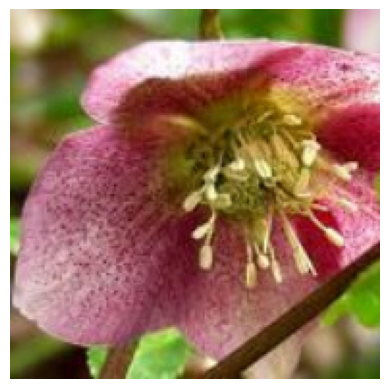

In [17]:
image = Image.open(io.BytesIO(val_images[0]))
plt.imshow(image)
plt.axis('off')
plt.show()

### Usable data -> Dataset

In [18]:
class MyDataset():
    def __init__(self, ids, label, imgs, transforms, is_test=False):
        self.ids = ids
        if not is_test:
            self.label = label
        self.imgs = imgs
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = Image.open(io.BytesIO(img))
        img = self.transforms(img)
        if self.is_test:
            return img, -1, self.ids[idx]
        return img, int(self.label[idx]), self.ids[idx]

### Normalize

In [19]:
train_transforms = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize each color
                        transforms.RandomErasing()
                    ])

test_transforms = transforms.Compose([
                        transforms.CenterCrop(224),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize each color
                    ])
# train_transforms = transforms.Compose([
#                         transforms.Resize(256),
#                         transforms.RandomResizedCrop(224),
#                         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                         transforms.RandomRotation(15),
#                     ])

# test_transforms = transforms.Compose([
#                         transforms.Resize(256),
#                         transforms.CenterCrop(224),
#                     ])

In [20]:
train_ds  = MyDataset(train_ids, train_class, train_images, train_transforms)
valid_ds = MyDataset(val_ids, val_class, val_images, test_transforms)

### Setup xla device for TPUs

The XLA part is based on:
- https://www.kaggle.com/code/georgiisirotenko/pytorch-tpu-baseline-flowers-tranlearning-ensemble?scriptVersionId=65472370&cellId=47

In [21]:
device = xm.xla_device()

### Dataset -> Dataloader

The `DistributedSampler` is used in distributed training scenarios, where the dataset is split across multiple processors (like TPU cores) to parallelize the training process. Here's what each argument does:

- `train_ds / valid_ds`: These are the training and validation datasets, respectively.
- `num_replicas`: This is the total number of TPU cores (or other processors) available for training. xm.xrt_world_size() fetches this number dynamically.
- `rank`: Each TPU core (or processor) is assigned a unique identifier or 'rank'. xm.get_ordinal() fetches the rank of the current process. This ensures each core works on a different part of the dataset.
- `shuffle`: When set to True, the sampler shuffles the dataset before splitting it among the cores. This is usually desirable for the training set but less common for validation.


In [22]:
train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_ds,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )

valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_ds,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )

train_loader = DataLoader(train_ds, 128, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, 128, sampler=valid_sampler, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Denormalize

In [23]:
def denormalize(img):

    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    img = img*std + mean

    return np.clip(img,0,1)

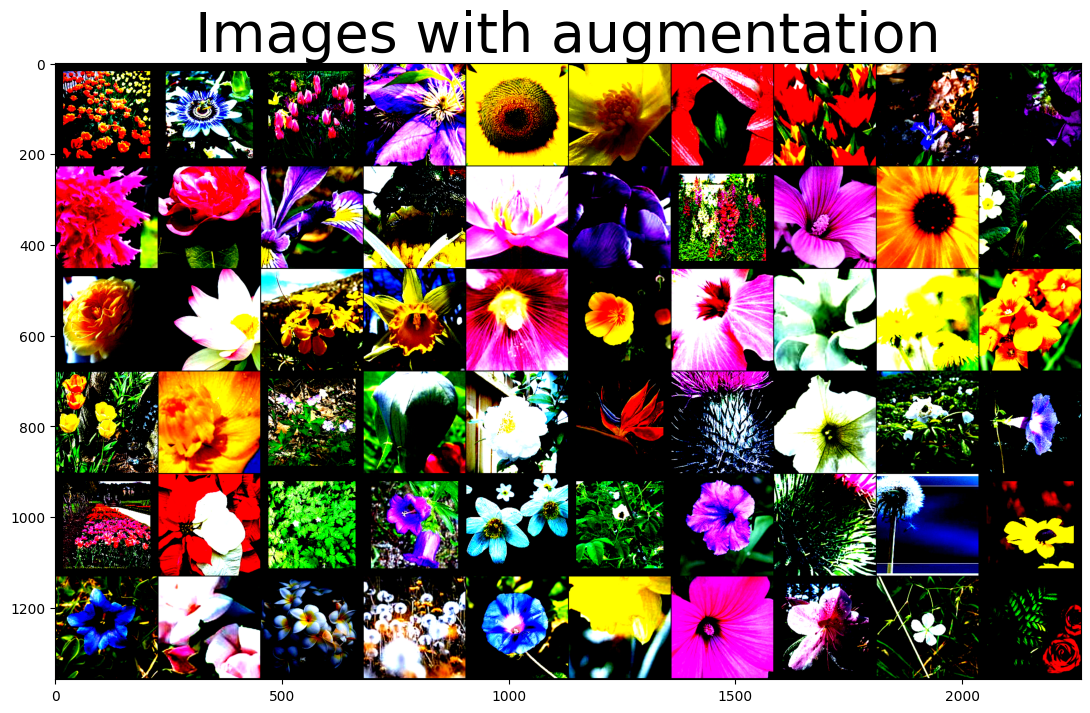

In [24]:
def show_batch(dl, is_denormalize=False):
      images, labels, _ = next(iter(dl))
      plt.figure(figsize=(16, 8))
      if is_denormalize:
        plt.imshow(denormalize(make_grid(images[:60], nrow=10)))
        plt.title('Images without augmentation', fontsize=40)
      else:
        plt.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        plt.title('Images with augmentation', fontsize=40)


show_batch(val_loader)

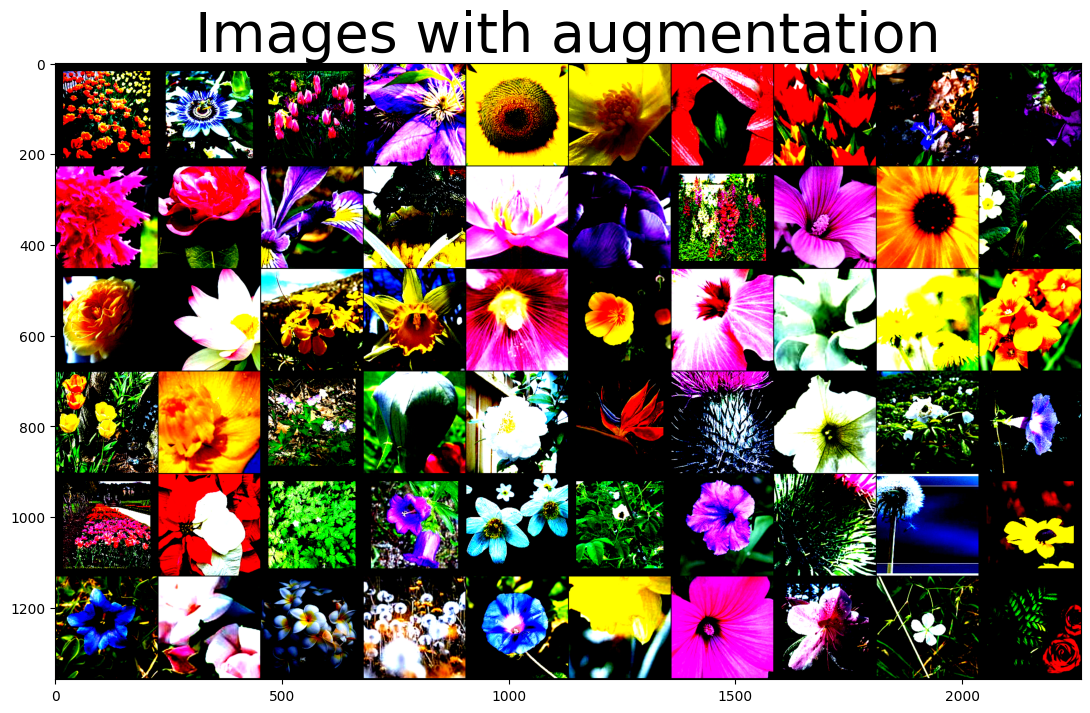

In [25]:
show_batch(val_loader)

##  Setup Necessary Functions

### Train One Epoch

In [26]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels, _ in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # optimizer.zero_grad() for the TPU distribution
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        xm.optimizer_step(optimizer)

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    return running_corrects, running_loss

### Test One Epoch

In [27]:
def evaluate(loader, model, loss_fn, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels, _ in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    return running_corrects, running_loss

### Optimizer

- The function sets up different optimizers based on the seed value. This suggests that the training process might be experimenting with training different parts of the model (like model.head, model.fc, or model.classifier) depending on the seed.

- Learning rates are scaled by `xm.xrt_world_size()`, which adjusts the learning rate according to the number of TPU cores being used.


In [28]:
def setup_optimizer(seed, model):
    """Setup optimizer based on the seed value."""
    lr = 0.001 * xm.xrt_world_size()

    # Head
    if seed == 1:
        return torch.optim.Adam(model.head.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # Fully connected
    elif seed in [2, 3]:
        return torch.optim.Adam(model.fc.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # Classifier
    elif seed in [4, 0]:
        return torch.optim.Adam(model.classifier.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # Invalid
    else:
        raise ValueError("Invalid seed value")

### Fit
- `xm.master_print`: Printing messages in a multi-core TPU environment.
- `xmp.MpModelWrapper`: Replicates model to make it works in a parllel processing.
- `pl.ParellelLoader`: Handle data loading in TPU


In [29]:
def fit(seed, epochs, model, train_loader, val_loader):
    """Fit the model to the training data."""
    xm.master_print(f'Creating a model {seed}...')
    device = xm.xla_device()
    model = xmp.MpModelWrapper(model).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = setup_optimizer(seed, model)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    start_time = time.time()

    for epoch in range(epochs):
        xm.master_print(f'Epoch: {epoch + 1}/{epochs}')

        # Training phase
        para_loader = pl.ParallelLoader(train_loader, [device])
        train_corrects, train_loss = train_one_epoch(para_loader.per_device_loader(device), model, optimizer, loss_fn, device)
        train_loss /= len(train_ds)
        train_acc = train_corrects / len(train_ds)
        xm.master_print(f'Train - Loss: {train_loss}, Accuracy: {train_acc}')

        # Validation phase
        para_loader = pl.ParallelLoader(val_loader, [device])
        val_corrects, val_loss = evaluate(para_loader.per_device_loader(device), model, loss_fn, device)
        val_loss /= len(valid_ds)
        val_acc = val_corrects / len(valid_ds)
        xm.master_print(f'Val - Loss: {val_loss}, Accuracy: {val_acc}')

        # Checkpointing
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())

        scheduler.step()
        elapsed_time = time.time() - start_time
        xm.master_print(f'Time elapsed: {elapsed_time // 60}m {elapsed_time % 60}s')

    # Load the best model
    model.load_state_dict(best_model)
    return model

## Getting a models

### DenseNet

In [30]:
densenet121 = torchvision.models.densenet121(pretrained=True)
for param in densenet121.parameters():
  param.requires_grad=False

densenet121.classifier = nn.Linear(in_features=densenet121.classifier.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 121MB/s]


### Vit

In [31]:
ViT  = timm.create_model("vit_base_patch16_224", pretrained=True)
for param in ViT.parameters():
  param.requires_grad=False

ViT.head = nn.Linear(ViT.head.in_features, 104)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### GoogLeNet

In [32]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 111MB/s]


### ResNet

In [33]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 115MB/s]


### VGG19

In [34]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, 104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:08<00:00, 66.0MB/s]


## Train the model

In [35]:
all_models = [densenet121, ViT] #, googlenet, resnet101, vgg19_bn
trained_models = []

In [ ]:
for seed in range(len(all_models)):
  model = all_models[seed]
  trained_model = fit(seed, 3, model, train_loader, val_loader)
  torch.save(trained_model.state_dict(), f'model_state_{seed}.pt')
  trained_models.append(trained_model)

Creating a model 0...
Epoch: 1/3


## Ensemble Prediction

In [ ]:
device